# IMPORT LIBS

In [1]:
import sys
sys.path.insert(1, "/home/lucas/AffectiveComputing")

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from libs.sqlite_manager import Sqlite as slq3
from libs.pre_processing import PreProcessing 
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import tensorflow as tf
from os import environ
from math import sqrt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")


model_name = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

pp = PreProcessing()

/usr/local/lib/python3.10/dist-packages/tqdm-4.65.0-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2024-01-10 18:05:33.256790: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-10 18:05:33.282528: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 18:05:33.282548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 18:05:33.283206: E external/loc

# EXEMPLO NO ARTIGO: CARROS E MOTOS

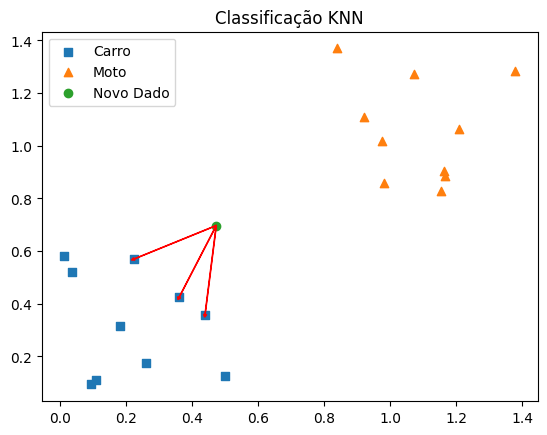

In [2]:
# Geração de dados aleatórios
np.random.seed(42)

# Grupo Quadrado
quadrados = np.random.rand(10, 2) * 0.6

# Grupo Triângulo
triangulos = 0.8 + np.random.rand(10, 2) * 0.6

# Novo ponto (círculo)
ponto_teste = 0.4 + np.random.rand(1, 2) * 0.6

# Criando rótulos para os grupos
rotulos_quadrados = np.zeros(10)
rotulos_triangulos = np.ones(10)

# Criando o conjunto de treinamento
conjunto_treinamento = np.vstack((quadrados, triangulos))
rotulos_treinamento = np.hstack((rotulos_quadrados, rotulos_triangulos))

# Aplicando KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(conjunto_treinamento, rotulos_treinamento)

# Obtendo os índices dos três vizinhos mais próximos
indices_vizinhos = knn.kneighbors(ponto_teste, n_neighbors=3, return_distance=False)[0]

# Classificando o novo ponto
grupo_pertencimento = knn.predict(ponto_teste)

# Visualizando o gráfico
plt.scatter(quadrados[:, 0], quadrados[:, 1], marker='s', label='Carro')
plt.scatter(triangulos[:, 0], triangulos[:, 1], marker='^', label='Moto')
plt.scatter(ponto_teste[:, 0], ponto_teste[:, 1], marker='o', label='Novo Dado')

# Adicionando setas para os três vizinhos mais próximos
for indice_vizinho in indices_vizinhos:
    vizinho = conjunto_treinamento[indice_vizinho]
    plt.arrow(ponto_teste[0, 0], ponto_teste[0, 1], vizinho[0] - ponto_teste[0, 0], vizinho[1] - ponto_teste[0, 1],
              head_width=0.01, head_length=0.01, fc='red', ec='red')

plt.title(f'Classificação KNN')
plt.legend()
plt.show()


## LOAD DATA

In [2]:
emotion_name = {0: 'admiração', 1: 'diversão', 2: 'raiva', 3: 'aborrecimento',
                4: 'provação', 5: 'confusão', 6: 'curiosidade', 7: 'desejo',
                8: 'decepção', 9: 'desaprovação', 10: 'nojo', 11: 'vergonha', 
                12: 'entusiasmo', 13: 'medo', 14: 'gratidão', 15: 'luto', 
                16: 'alegria', 17: 'amor', 18: 'nervosismo', 19: 'otimismo',
                20: 'orgulho', 21: 'alívio', 22: 'remorso', 23: 'tristeza',  
                24: 'surpresa', 25: 'saudade', 26: 'inveja', 27: 'compaixão'}
emotion_name

{0: 'admiração',
 1: 'diversão',
 2: 'raiva',
 3: 'aborrecimento',
 4: 'provação',
 5: 'confusão',
 6: 'curiosidade',
 7: 'desejo',
 8: 'decepção',
 9: 'desaprovação',
 10: 'nojo',
 11: 'vergonha',
 12: 'entusiasmo',
 13: 'medo',
 14: 'gratidão',
 15: 'luto',
 16: 'alegria',
 17: 'amor',
 18: 'nervosismo',
 19: 'otimismo',
 20: 'orgulho',
 21: 'alívio',
 22: 'remorso',
 23: 'tristeza',
 24: 'surpresa',
 25: 'saudade',
 26: 'inveja',
 27: 'compaixão'}

In [3]:
path =  environ['PATH_TEST_DATASET']
data = pd.read_csv(path, delimiter='\t')

data

,tweet_id,tweet,categoria
0,1407499359386734594,admiro o povo que tem paciência,0
1,1407463939517173763,O único jogo que jogo bem é o Guitar Hero. É p...,0
2,1407523515645956097,Amg eu dei uma olhadinha tá muito incrível 🥺😍😍...,0
3,1407524564075171842,sexooo,0
4,1407525154884833281,Sempre foi de direita. Ela não está nem aí par...,0
...,...,...,...
13080,1407707182725046276,como não aproveitar #aşktankaçma,27
13081,1407707358583832586,falta 1 mês pro meu aniversário e eu não aceit...,27
13082,1407707475697192960,Vai embora do Corinthians não aceitamos racist...,27
13083,1407707496773468165,"neste perfil não aceito críticas à gatos, seje...",27


# KNN


In [5]:
def _preprocessing_train(dataframe, column):
    dataframe = pp.dropnan_and_lowercase(dataframe, column)
    dataframe = pp.change_abbreviations_dataframe(dataframe, column)
    dataframe = pp.drop_size(dataframe, column, 3)
    dataframe = pp.set_category(dataframe, 'categoria')
    dataframe = pp.apply_regex_dataframe(dataframe, column)
    dataframe = pp.shuffled_dataframe(dataframe)
    dataframe = pp.remove_stopwords_dataframe(dataframe, column)
    return dataframe

In [6]:
data = _preprocessing_train(data, "tweet")
texts = data.tweet
labels = np.array(data.categoria.tolist())

texts_train, texts_val, labels_train, labels_val = train_test_split(texts, labels, test_size=0.2, random_state=42)

texts_train = texts_train.tolist()

inputs_train = tokenizer(texts_train, max_length=64, padding=True, truncation=True, return_tensors='tf')

labels_train = tf.convert_to_tensor(labels_train, dtype=tf.int64)

inputs_train_ids = inputs_train['input_ids']
inputs_train_ids = np.array(inputs_train_ids).astype(int)

labels_train_np = labels_train.numpy()

texts_val = texts_val.tolist()
inputs_val = tokenizer(texts_val, max_length=64, padding=True, truncation=True, return_tensors='tf')
inputs_val_ids = np.array(inputs_val['input_ids']).astype(int)

2023-12-27 14:17:46.864701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-27 14:17:46.865256: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
size_sqrt = int(sqrt(len(inputs_train_ids)))
param_dist = {
    'n_neighbors': np.arange(3, size_sqrt, 2),
    'weights': ['uniform', 'distance'],
    'p': [1, 2], 
    'metric': ['manhattan', "euclidean", "cosine"]
}


knn_classifier = KNeighborsClassifier()

random_search = GridSearchCV(knn_classifier,param_dist, cv=5, scoring='accuracy')

random_search.fit(inputs_train_ids, labels_train_np)  

best_params = random_search.best_params_

best_knn_classifier = random_search.best_estimator_

predictions = best_knn_classifier.predict(inputs_val_ids)

accuracy = accuracy_score(labels_val, predictions)
print(f'Melhores valores para os hiperparâmetros: {best_params}')
print(f'Acurácia com o melhor modelo: {accuracy}')


Melhores valores para os hiperparâmetros: {'metric': 'manhattan', 'n_neighbors': 95, 'p': 1, 'weights': 'distance'}
Acurácia com o melhor modelo: 0.15593762495002


In [8]:
labels_val_names = [emotion_name[label] for label in labels_val]
pred_labels_names = [emotion_name[label] for label in predictions]
report = classification_report(labels_val_names, pred_labels_names)

print(report)

               precision    recall  f1-score   support

aborrecimento       1.00      0.05      0.10        57
    admiração       0.16      0.12      0.14       129
      alegria       0.09      0.02      0.03       111
       alívio       0.43      0.05      0.09        59
         amor       1.00      0.08      0.14        79
    compaixão       0.00      0.00      0.00        49
     confusão       0.14      0.55      0.22       279
  curiosidade       1.00      0.02      0.03        61
     decepção       0.25      0.05      0.08        42
 desaprovação       0.00      0.00      0.00        32
       desejo       0.12      0.23      0.16       200
     diversão       0.12      0.16      0.14       203
   entusiasmo       0.15      0.03      0.04       120
     gratidão       0.00      0.00      0.00         5
       inveja       0.18      0.07      0.10        70
         luto       0.40      0.06      0.10        72
         medo       0.15      0.26      0.19       115
   nervos

# KNN BIGGER

In [2]:
path = "/home/lucas/AffectiveComputing/songs_database.db"
slq3_instance = slq3(database=path)
inputs = slq3_instance.get_by_select(query='SELECT * FROM inputs;')
emotion_name = slq3_instance.get_by_select(query="SELECT name_emotion FROM emotion")
emotion_name = emotion_name.to_dict()["name_emotion"]
inputs = pp.shuffled_dataframe(inputs)


In [3]:
texts = inputs.text_name
labels = np.array(inputs.emotion_id.tolist())
texts_train, texts_val, labels_train, labels_val = train_test_split(texts, labels, test_size=0.3, random_state=42)

texts_train = texts_train.tolist()

inputs_train = tokenizer(texts_train, max_length=64, padding=True, truncation=True, return_tensors='tf')

labels_train = tf.convert_to_tensor(labels_train, dtype=tf.int64)

inputs_train_ids = inputs_train['input_ids']
inputs_train_ids = np.array(inputs_train_ids).astype(int)

labels_train_np = labels_train.numpy()

texts_val = texts_val.tolist()
inputs_val = tokenizer(texts_val, max_length=64, padding=True, truncation=True, return_tensors='tf')
inputs_val_ids = np.array(inputs_val['input_ids']).astype(int)

2024-01-10 18:05:46.931925: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-10 18:05:46.936074: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
param_dist = {
    'n_neighbors': np.arange(3, 51, 2),
    'weights': ['uniform', 'distance'],
    'p': [1, 2], 
    'metric': ['manhattan', "euclidean", "cosine"]
}


knn_classifier = KNeighborsClassifier()

random_search = GridSearchCV(knn_classifier,param_dist, cv=5, scoring='accuracy')

random_search.fit(inputs_train_ids, labels_train_np)  

best_params = random_search.best_params_

best_knn_classifier = random_search.best_estimator_

predictions = best_knn_classifier.predict(inputs_val_ids)

accuracy = accuracy_score(labels_val, predictions)
print(f'Melhores valores para os hiperparâmetros: {best_params}')
print(f'Acurácia com o melhor modelo: {accuracy}')

Melhores valores para os hiperparâmetros: {'metric': 'manhattan', 'n_neighbors': 25, 'p': 1, 'weights': 'distance'}
Acurácia com o melhor modelo: 0.21264884295663897


In [13]:
labels_val_names = [emotion_name[label] for label in labels_val]
pred_labels_names = [emotion_name[label] for label in predictions]
report = classification_report(labels_val_names, pred_labels_names)

print(report)

               precision    recall  f1-score   support

aborrecimento       0.28      0.37      0.32       204
    admiração       0.31      0.45      0.37       298
      alegria       0.20      0.13      0.16       212
       alívio       0.28      0.31      0.29       210
         amor       0.08      0.06      0.07       190
    compaixão       0.23      0.26      0.24       219
     confusão       0.14      0.12      0.13       323
  curiosidade       0.22      0.23      0.23       193
     decepção       0.11      0.09      0.10       200
 desaprovação       0.27      0.41      0.33       191
       desejo       0.14      0.09      0.11       207
     diversão       0.09      0.06      0.07       208
   entusiasmo       0.12      0.12      0.12       194
     gratidão       0.24      0.41      0.30       201
       inveja       0.42      0.49      0.45       226
         luto       0.19      0.16      0.17       193
         medo       0.18      0.14      0.16       223
   nervos

# SAVE MODEL

In [6]:
import joblib



# Caminho para a pasta
caminho_pasta = "/home/lucas/AffectiveComputing/model/"


caminho_modelo = caminho_pasta + "KNN.keras"
joblib.dump(best_knn_classifier, caminho_modelo)

print(f"Modelo salvo em: {caminho_modelo}")

Modelo salvo em: /home/lucas/AffectiveComputing/model/KNN.keras


In [7]:
model_load = joblib.load(caminho_modelo)
model_load

KNeighborsClassifier(metric='manhattan', n_neighbors=25, p=1,
                     weights='distance')